# Ensembles: Bagging

In [1]:
import numpy as np
import pandas as pd
import xlrd
import os
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,\
ExtraTreesClassifier, VotingClassifier, StackingRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Objectives

- Use `sklearn` to build voting models
- Describe the algorithm of bagging
- Describe the differences among simple bagging, random forest, and extra trees algorithms
- Implement bagging models in `sklearn`

# Ensemble Methods

Because many heads are better than one!

<img width=50% src='images/captain_planet.jpg'/>

> "With our powers combined..."

These models tend to perform very well and generalize well!

## Advantages &  Disadvantages

- Decreases variance → Less overfitting!
- More complexity (you have to train each model or part of model)
- Tends to take up more space (have to keep each model)

## Bagging 

![](images/bag_of_marbles.jpg)

- Many models naturally overfit
- Randomization → New models
- New models overfit in different ways
- Aggregation → Smooth over different ways of overfitting to reduce variance

> Low variance since it averages out quirks individual trees might've learned

1000 observations and 10 features

-> 300 observations and 7 features

#### Aggregation

- **B**ootstrap **AGG**regating
- Algorithm to repeat many times:
    + Create a sample from your data
    + Train a model (e.g. a decision tree) on that sample
- Final model comes by averaging over those many models

#### Three Varieties, Three Levels of Randomization

1. **Simple Bag**: Train each model on random sample
2. **Random Forest**: Choose a random set of features at each decision point
3. **Extra Trees**: Choose a path at random!

## Data Preparation for Examples

> Let's prepare some data to do some examples

In [2]:
df = pd.read_csv('data/cars.csv')
df.head()

,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year,brand
0,14.0,8,350,165,4209,12,1972,US.
1,31.9,4,89,71,1925,14,1980,Europe.
2,17.0,8,302,140,3449,11,1971,US.
3,15.0,8,400,150,3761,10,1971,US.
4,30.5,4,98,63,2051,17,1978,US.


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           261 non-null    float64
 1    cylinders    261 non-null    int64  
 2    cubicinches  261 non-null    object 
 3    hp           261 non-null    int64  
 4    weightlbs    261 non-null    object 
 5    time-to-60   261 non-null    int64  
 6    year         261 non-null    int64  
 7    brand        261 non-null    object 
dtypes: float64(1), int64(4), object(3)
memory usage: 16.4+ KB


In [4]:
df.isna().sum().sum()

0

### Defining Our Problem

Let's see if we can predict whether a car is American or not.

In [5]:
df[' brand'].value_counts()

 US.        162
 Japan.      51
 Europe.     48
Name:  brand, dtype: int64

In [6]:
df['target'] = df[' brand'] == ' US.'

In [7]:
df.head()

,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year,brand,target
0,14.0,8,350,165,4209,12,1972,US.,True
1,31.9,4,89,71,1925,14,1980,Europe.,False
2,17.0,8,302,140,3449,11,1971,US.,True
3,15.0,8,400,150,3761,10,1971,US.,True
4,30.5,4,98,63,2051,17,1978,US.,True


### Fix Columns with Missing Values

In [8]:
# Convert cubicinches and weightlbs to numbers
df[df[' cubicinches'] == ' ']

,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year,brand,target
40,16.0,6,,105,3897,19,1976,US.,True
180,19.8,6,,85,2990,18,1980,US.,True


In [9]:
df[' cubicinches'] = df[' cubicinches'].map(lambda x: np.nan if x == ' ' else int(x))

In [10]:
df[df[' weightlbs'] == ' ']

,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year,brand,target
14,19.1,6,225.0,90,,19,1981,US.,True
33,21.0,6,199.0,90,,15,1971,US.,True
172,29.0,4,68.0,49,,20,1974,Europe.,False


In [11]:
df[' weightlbs'] = df[' weightlbs'].map(lambda x: np.nan if x == ' ' else int(x))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['target', ' brand'], axis=1), df['target'], random_state=42)

In [13]:
si = SimpleImputer()

si.fit(X_train)

X_tr_im = si.transform(X_train)
X_te_im = si.transform(X_test)

## Averaging

> Each model uses the same data to train and then we "vote" to make a prediction

### Model 1 - Logistic Regression

In [14]:
lr = LogisticRegression(max_iter=1000, random_state=42)

lr.fit(X_tr_im, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [15]:
scores = cross_val_score(estimator=lr, X=X_tr_im,
                        y=y_train, cv=5)
scores

array([0.84615385, 0.92307692, 0.76923077, 0.94871795, 0.79487179])

In [16]:
np.median(scores)

0.8461538461538461

In [17]:
lr.score(X_te_im, y_test)

0.8939393939393939

### Model 2 - KNN

In [18]:
knn = KNeighborsClassifier(3)

knn.fit(X_tr_im, y_train)

KNeighborsClassifier(n_neighbors=3)

In [19]:
scores = cross_val_score(estimator=knn, X=X_tr_im,
                y=y_train, cv=5)
np.median(scores)

0.7692307692307693

In [20]:
knn.score(X_te_im, y_test)

0.7878787878787878

### Model 3 - Decision Tree

In [21]:
ct = DecisionTreeClassifier(random_state=42)

ct.fit(X_tr_im, y_train)

DecisionTreeClassifier(random_state=42)

In [22]:
scores = cross_val_score(estimator=ct, X=X_tr_im,
               y=y_train, cv=5)
scores

array([0.8974359 , 0.87179487, 0.82051282, 0.8974359 , 0.79487179])

In [23]:
np.median(scores)

0.8717948717948718

In [24]:
ct.score(X_te_im, y_test)

0.7878787878787878

### Averaging the Models

#### Building a `VotingClassifier`

> Of course there's a Scikit-Learn class for that!

In [25]:
avg = VotingClassifier(estimators=[
    ('lr', lr),
    ('knn', knn),
    ('ct', ct)])
avg.fit(X_tr_im, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(max_iter=1000,
                                                 random_state=42)),
                             ('knn', KNeighborsClassifier(n_neighbors=3)),
                             ('ct', DecisionTreeClassifier(random_state=42))])

In [26]:
scores = cross_val_score(estimator=avg, X=X_tr_im,
               y=y_train, cv=5)
scores

array([0.87179487, 0.8974359 , 0.82051282, 0.8974359 , 0.79487179])

In [27]:
np.median(scores)

0.8717948717948718

In [28]:
avg.score(X_te_im, y_test)

0.8636363636363636

#### Weighted Averaging with the `VotingClassifier`

> Even if the vote is 50-50, you'd probably side with the "smart" ones more

This meta-estimator is not as good as one of our base estimators, so in this case the averaging did not work very well. Realizing that the logistic regression is performing better than the decision tree and the k-nearest-neighbors model, however, we might decide to build a meta-estimator by calculating a **weighted average** of the base estimators' predictions. And we can weight, or bias, this estimator in favor of the best-performing base estimator. Suppose we weight the logistic regression 50%, the knn model 25%, and the logistic regression 25%:

In [29]:
w_avg = VotingClassifier(estimators=[
    ('lr', lr),
    ('knn', knn),
    ('ct', ct)],
    weights=[0.5, 0.25, 0.25])
w_avg.fit(X_tr_im, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(max_iter=1000,
                                                 random_state=42)),
                             ('knn', KNeighborsClassifier(n_neighbors=3)),
                             ('ct', DecisionTreeClassifier(random_state=42))],
                 weights=[0.5, 0.25, 0.25])

In [30]:
scores = cross_val_score(estimator=w_avg, X=X_tr_im,
                        y=y_train, cv=5)
scores

array([0.87179487, 0.92307692, 0.79487179, 0.92307692, 0.79487179])

In [31]:
np.median(scores)

0.8717948717948718

In [32]:
w_avg.score(X_te_im, y_test)

0.9242424242424242

## Bagging

A single decision tree will often overfit your training data. Let's see if we have evidence of that in the current case:

In [33]:
ct.score(X_tr_im, y_train)

1.0

<details>
    <summary><b>🧠 Knowledge Check</b>: What is this score? And why is it equal to 1?</summary>
    <br/>
    <quote>
    This perfect score on the training data is already evidence of model overfitting. There are steps one can take to help with this, like limiting the "depth" of the nodes. And of course we can use cross-validation to get a more honest estimate of model quality.
    </quote>
</details>




In [34]:
scores = cross_val_score(estimator=ct, X=X_tr_im,
                y=y_train, cv=5)
scores

array([0.8974359 , 0.87179487, 0.82051282, 0.8974359 , 0.79487179])

In [35]:
np.median(scores)

0.8717948717948718

In [36]:
ct.score(X_te_im, y_test)

0.7878787878787878

But it's often better to do something else: Plant another tree!

Of course, if a second tree is going to be of any value, it has to be *different from* the first. Here's a good algorithm for achieving that:

### Bagging Algorithm

- Take a sample of your X_train and fit a decision tree to it.
- Replace the first batch of data and repeat.
- When you've got as many trees as you like, make use of all your individual trees' predictions to come up with some holistic prediction. 
    - (Most obviously, we could take the average of our predictions, but there are other methods we might try.)

* Because we're resampling our data with replacement, we're *bootstrapping*.
* Because we're making use of our many samples' predictions, we're *aggregating*.
* Because we're bootstrapping and aggregating all in the same algorithm, we're *bagging*.

### Bagging by Hand

In [37]:
def simple_bagger(X_train, y_train, X_test=None, n_trees=10):
    """
    This function will build `n_trees`-many decision tree classifiers
    with random_state=42 on subsets of X_train (and y_train), returning
    average predictions (averaging on the .predict_proba() method of the
    decision trees as opposed to the .predict() method) on X_test. If X_test
    is not specified, the function will predict on X_train.
    """
    import numpy as np
    if X_test is None:
        X_test = X_train
    y_train = y_train.values.reshape(-1, 1)
    data = np.hstack((X_train, y_train))
    num_recs = y_train.shape[0]
    preds = []
    for _ in range(n_trees):
        
        # Train on 10% of the training data
        subset = np.random.choice(num_recs, size=num_recs//10)
            # Note that there is still randomness here!
        training = data[subset, :]
        ct = DecisionTreeClassifier(random_state=42)
        ct.fit(training[:, :-1], training[:, -1])
        preds.append(ct.predict_proba(X_test))
    return np.mean(preds, axis=0).argmax(axis=1)

In [38]:
simple_bagger(X_tr_im, y_train)

array([1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0])

In [39]:
ct = DecisionTreeClassifier(random_state=42)

ct.fit(X_tr_im, y_train)
ct.score(X_te_im, y_test)

0.7878787878787878

In [40]:
accuracy_score(y_test, simple_bagger(X_tr_im, y_train, X_te_im, n_trees=10))

0.8939393939393939

### Bagging with `sklearn`

In [41]:
# Instatiate a BaggingRegessor
# Note the base esimator is by default a decision tree
bag = BaggingClassifier(n_estimators=100,
                       random_state=42)

In [42]:
# Fit it

bag.fit(X_tr_im, y_train)

BaggingClassifier(n_estimators=100, random_state=42)

In [43]:
# Cross-validation

scores = cross_val_score(estimator=bag, X=X_tr_im,
               y=y_train, cv=5)
scores

array([0.8974359 , 0.92307692, 0.84615385, 0.92307692, 0.82051282])

In [44]:
np.median(scores)

0.8974358974358975

In [45]:
# Score on test

bag.score(X_te_im, y_test)

0.8484848484848485

### Fitting a Random Forest

### An Aside Story - Bananas 🍌

Banana trees can be susceptible to [Panama's disease](https://en.wikipedia.org/wiki/Panama_disease)

![Many individual yellow bananas](images/bananas.jpg)

They're all clones!

Similarly, all the Decision Trees will be the same if given the same data! (A clone!!!)

### The Goods & The Bads

**The Goods**

- Super friend! 
- High performance 
    + low variance
- Transparent
    + inherited from Decision Trees
    

**The Bads**

- We got so many trees to plant...
- Computationally expensive
- Memory
    + all trees stored in memory
    + think back to k-Nearest Neighbors

### Breed a Variety of Trees

Let's add an extra layer of randomization: Instead of using *all* the features of my model to optimize a branch at each node, I'll just choose a subset of my features.

That's the essence of a random forest model. Note that there are now **two** levels of random sampling happening: To build a new tree, I'll be taking only some of my data points; and at any branching point in a tree, I'll be using only some of my features to determine the split.

#### Steps:

1. Save a portion of data for validation (**out-of-bag**), the rest for training (**bag**)
2. The data for training (**bag**) is then split up by randomly selecting predictors
3. Grow/train your tree with the training data using just those features
4. Use our validation set (**out-of-bag**), take out the columns used in our tree from the previous step, and predict using the tree & this *out-of-bag* data
5. Compare on how well the tree did *out-of-bag error*
6. Repeat to make new trees and use the result to "vote" for the final decision

### Random Forest by Hand

In [46]:
def bagger(X_train, y_train, X_test=None, n_trees=10, random_forest=False):
    """
    This function will build `n_trees`-many decision tree classifiers
    with random_state=42 on subsets of X_train (and y_train), returning
    average predictions (averaging on the .predict_proba() method of the
    decision trees as opposed to the .predict() method) on X_test. If X_test
    is not specified, the function will predict on X_train. If `random_forest`
    is set to True, a number of features equal to sqrt(n_features) will be
    used to build each tree.
    """
    import numpy as np
    if X_test is None:
        X_test = X_train
    y_train = y_train.values.reshape(-1, 1)
    data = np.hstack((X_train, y_train))
    num_recs = X_train.shape[0]
    num_feats = X_train.shape[1]
    preds = []
    for _ in range(n_trees):
        
        # Train on 10% of the training data
        subset = np.random.choice(num_recs, size=num_recs//10).reshape(-1, 1)
        
        # For random forest, choose only some features
        if random_forest == True:
            subfeatures = np.random.choice(num_feats, size=int(np.sqrt(num_feats)))
        else:
            subfeatures = np.arange(num_feats)
        subfeatures_y = np.append(subfeatures, -1).reshape(1, -1)
        training = data[subset, subfeatures_y]
        ct = DecisionTreeClassifier(random_state=42)
        ct.fit(training[:, :-1], training[:, -1])
        preds.append(ct.predict_proba(X_test[:, subfeatures]))
    return np.mean(preds, axis=0).argmax(axis=1)

In [47]:
accuracy_score(y_test, bagger(X_tr_im, y_train, X_te_im, random_forest=True))

0.803030303030303

### Random Forest with `sklearn`

> Here's the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) on `RandomForestClassifier`

In [48]:
# Instantiate a RandomForestClassifier

rfc = RandomForestClassifier(max_features='sqrt',
                            max_samples=0.3,
                            random_state=1)

In [49]:
# Fit it

rfc.fit(X_tr_im, y_train)

RandomForestClassifier(max_samples=0.3, random_state=1)

In [50]:
# Cross-validation

scores = cross_val_score(estimator=rfc, X=X_tr_im,
               y=y_train, cv=5)
scores

array([0.87179487, 0.94871795, 0.87179487, 0.8974359 , 0.82051282])

In [51]:
np.median(scores)

0.8717948717948718

In [52]:
# Score on test

score = rfc.score(X_te_im, y_test)
score

0.8939393939393939

### Cool Features of Random Forests

There are some extra investigations we can do with random forests since they're built of decision trees.

> **NOTE**
>
> Not all of these are _specific_ to random forests and can be applied to other (ensemble) models

#### Investigate Your Forest 🌲🌲👀🌲🌲

We can check out our trained estimators after training the ensemble. This isn't necessarily unique to random forests, but since the base model is always a decision tree we can really investigate how the model is working!

In [53]:
model_estimators = rfc.estimators_ 
print(len(model_estimators))
model_estimators

100


[DecisionTreeClassifier(max_features='sqrt', random_state=1791095845),
 DecisionTreeClassifier(max_features='sqrt', random_state=2135392491),
 DecisionTreeClassifier(max_features='sqrt', random_state=946286476),
 DecisionTreeClassifier(max_features='sqrt', random_state=1857819720),
 DecisionTreeClassifier(max_features='sqrt', random_state=491263),
 DecisionTreeClassifier(max_features='sqrt', random_state=550290313),
 DecisionTreeClassifier(max_features='sqrt', random_state=1298508491),
 DecisionTreeClassifier(max_features='sqrt', random_state=2143362693),
 DecisionTreeClassifier(max_features='sqrt', random_state=630311759),
 DecisionTreeClassifier(max_features='sqrt', random_state=1013994432),
 DecisionTreeClassifier(max_features='sqrt', random_state=396591248),
 DecisionTreeClassifier(max_features='sqrt', random_state=1703301249),
 DecisionTreeClassifier(max_features='sqrt', random_state=799981516),
 DecisionTreeClassifier(max_features='sqrt', random_state=1666063943),
 DecisionTreeCl

In [54]:
print(f'Overall model\'s score was {score:.3f}')
print('='*70)

for model in model_estimators[-5:]:
    display(model)
    model_score = model.score(X_te_im, y_test)
    print(f'\tModel gave score of {model_score:.3f}')

Overall model's score was 0.894


DecisionTreeClassifier(max_features='sqrt', random_state=1732461694)

	Model gave score of 0.773


DecisionTreeClassifier(max_features='sqrt', random_state=1235985687)

	Model gave score of 0.667


DecisionTreeClassifier(max_features='sqrt', random_state=513207677)

	Model gave score of 0.894


DecisionTreeClassifier(max_features='sqrt', random_state=558468452)

	Model gave score of 0.879


DecisionTreeClassifier(max_features='sqrt', random_state=106512539)

	Model gave score of 0.848


[Text(0.8333333333333334, 0.95, 'x[4] <= 3234.0\ngini = 0.49\nsamples = 51\nvalue = [25, 33]'),
 Text(0.75, 0.85, 'x[2] <= 184.0\ngini = 0.408\nsamples = 31\nvalue = [25, 10]'),
 Text(0.6666666666666666, 0.75, 'x[4] <= 2785.0\ngini = 0.367\nsamples = 29\nvalue = [25, 8]'),
 Text(0.5833333333333334, 0.65, 'x[2] <= 128.0\ngini = 0.426\nsamples = 24\nvalue = [18, 8]'),
 Text(0.5, 0.55, 'x[4] <= 2260.0\ngini = 0.34\nsamples = 21\nvalue = [18, 5]'),
 Text(0.4166666666666667, 0.45, 'x[5] <= 18.5\ngini = 0.43\nsamples = 15\nvalue = [11, 5]'),
 Text(0.3333333333333333, 0.35, 'x[5] <= 17.5\ngini = 0.486\nsamples = 12\nvalue = [7, 5]'),
 Text(0.25, 0.25, 'x[0] <= 34.35\ngini = 0.463\nsamples = 11\nvalue = [7, 4]'),
 Text(0.16666666666666666, 0.15, 'x[4] <= 2224.5\ngini = 0.219\nsamples = 8\nvalue = [7, 1]'),
 Text(0.08333333333333333, 0.05, 'gini = 0.0\nsamples = 7\nvalue = [7, 0]'),
 Text(0.25, 0.05, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.3333333333333333, 0.15, 'gini = 0.0\nsample

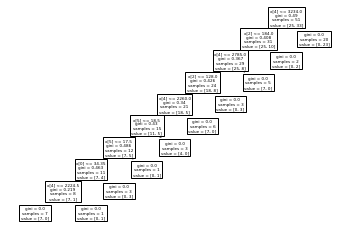

In [55]:
from sklearn.tree import plot_tree

plot_tree(rfc.estimators_[0])

[Text(0.6, 0.9166666666666666, 'x[2] <= 132.5\ngini = 0.383\nsamples = 51\nvalue = [15, 43]'),
 Text(0.5, 0.75, 'x[0] <= 30.45\ngini = 0.434\nsamples = 17\nvalue = [15, 7]'),
 Text(0.2, 0.5833333333333334, 'x[2] <= 104.5\ngini = 0.231\nsamples = 11\nvalue = [13, 2]'),
 Text(0.1, 0.4166666666666667, 'gini = 0.0\nsamples = 6\nvalue = [7, 0]'),
 Text(0.3, 0.4166666666666667, 'x[5] <= 16.5\ngini = 0.375\nsamples = 5\nvalue = [6, 2]'),
 Text(0.2, 0.25, 'gini = 0.0\nsamples = 3\nvalue = [6, 0]'),
 Text(0.4, 0.25, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0.8, 0.5833333333333334, 'x[2] <= 92.0\ngini = 0.408\nsamples = 6\nvalue = [2, 5]'),
 Text(0.7, 0.4166666666666667, 'x[0] <= 38.1\ngini = 0.444\nsamples = 3\nvalue = [2, 1]'),
 Text(0.6, 0.25, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.8, 0.25, 'x[5] <= 17.0\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(0.7, 0.08333333333333333, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.9, 0.08333333333333333, 'gini = 0.0\nsamp

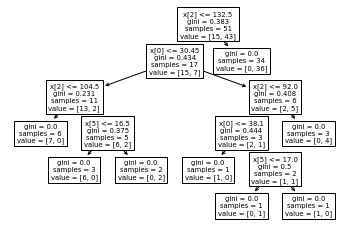

In [56]:
plot_tree(rfc.estimators_[30])

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           261 non-null    float64
 1    cylinders    261 non-null    int64  
 2    cubicinches  259 non-null    float64
 3    hp           261 non-null    int64  
 4    weightlbs    258 non-null    float64
 5    time-to-60   261 non-null    int64  
 6    year         261 non-null    int64  
 7    brand        261 non-null    object 
 8   target        261 non-null    bool   
dtypes: bool(1), float64(3), int64(4), object(1)
memory usage: 16.7+ KB


#### Feature Importance

We can use [`.feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.feature_importances_) property of the trained model to get an idea of what features mattered the most

In [58]:
feat_import = {name: score 
                   for name, score 
                       in zip(X_train.columns, rfc.feature_importances_)
}
feat_import

{'mpg': 0.08827422709750767,
 ' cylinders': 0.11689087936658965,
 ' cubicinches': 0.31199490122230267,
 ' hp': 0.13508731623848755,
 ' weightlbs': 0.22123497825026436,
 ' time-to-60': 0.059762692890062565,
 ' year': 0.06675500493478545}

<AxesSubplot:>

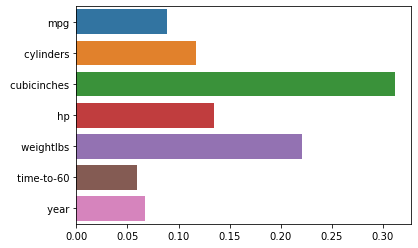

In [59]:
import seaborn as sns

sns.barplot(x = list(feat_import.values()), y = list(feat_import.keys()))

<AxesSubplot:xlabel='target', ylabel=' cubicinches'>

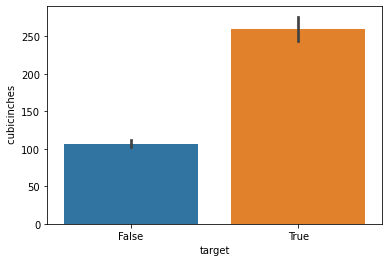

In [62]:
sns.barplot(x = "target", y = " cubicinches", data = df)

<AxesSubplot:xlabel='target', ylabel=' weightlbs'>

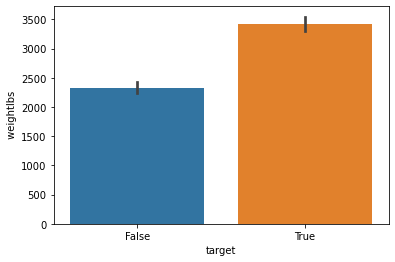

In [63]:
sns.barplot(x = "target", y = " weightlbs", data = df)

### Extremely Randomized Trees (Extra Trees)

Sometimes we might want even one more bit of randomization. Instead of always choosing the *optimal* branching path, we might just choose a branching path at random. If we're doing that, then we've got extremely randomized trees.

There are now **three** levels of randomization: sampling of data, sampling of features, and random selection of branching paths.

In [56]:
# Instantiate an ExtraTreesRegressor

etc = ExtraTreesClassifier(max_features='sqrt',
                         max_samples=0.5,
                         bootstrap=True,
                         random_state=1)

In [57]:
# Fit it

etc.fit(X_tr_im, y_train)

ExtraTreesClassifier(bootstrap=True, max_samples=0.5, random_state=1)

In [58]:
# Cross-validation

scores = cross_val_score(estimator=etc, X=X_tr_im,
               y=y_train, cv=5)
scores

array([0.84615385, 0.8974359 , 0.84615385, 0.92307692, 0.82051282])

In [59]:
np.median(scores)

0.8461538461538461

In [60]:
# Score on test

etc.score(X_te_im, y_test)

0.8484848484848485

# Level Up: Stacking

#### Meta-Classifier/Meta-Regressor

- First, we ask several different models to make predictions about the target
- Rather than taking a simple average or vote to determine the outcome, feed these results into a final model that makes the prediction based on the other models’ predictions
- If it seems like we are approaching a neural network...you are correct!

Remember weighted averaging? Stacking is about using DS models to estimate those weights for us. This means we'll have one layer of base estimators and another layer that is "**trained to optimally combine the model predictions to form a new set of predictions**". See [this short blog post](https://blogs.sas.com/content/subconsciousmusings/2017/05/18/stacked-ensemble-models-win-data-science-competitions/) for more.

## Initial Data Prep

In [61]:
wb = xlrd.open_workbook('data/Sales Report.xls',
                        logfile=open(os.devnull, 'w'))

sales = pd.read_excel(wb)
sales = sales.dropna()

In [62]:
sales.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2017-138688,2017-06-12,2017-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [63]:
sales.dtypes

Row ID                    int64
Order ID                 object
Order Date       datetime64[ns]
Ship Date        datetime64[ns]
Ship Mode                object
Customer ID              object
Customer Name            object
Segment                  object
Country                  object
City                     object
State                    object
Postal Code             float64
Region                   object
Product ID               object
Category                 object
Sub-Category             object
Product Name             object
Sales                   float64
Quantity                  int64
Discount                float64
Profit                  float64
dtype: object

In [64]:
sales['Category'].value_counts()

Office Supplies    6020
Furniture          2119
Technology         1844
Name: Category, dtype: int64

In [65]:
sales['Sub-Category'].value_counts()

Binders        1523
Paper          1368
Furnishings     957
Phones          888
Storage         845
Art             795
Accessories     773
Chairs          616
Appliances      465
Labels          364
Tables          319
Envelopes       253
Bookcases       227
Fasteners       217
Supplies        190
Machines        115
Copiers          68
Name: Sub-Category, dtype: int64

In [66]:
X_num = sales[['Discount', 'Profit']].columns
X_cat = sales[['Category', 'Sub-Category']].columns

In [67]:
X = sales[['Discount', 'Profit',
          'Category', 'Sub-Category']]
y = sales['Sales']

## Splitting

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Setting Up a Pipeline

In [69]:
numTrans = Pipeline(steps=[
    ('scaler', StandardScaler())
])
catTrans = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop='first',
                          sparse=False))
])

In [70]:
pp = ColumnTransformer(transformers=[
    ('num', numTrans, X_num),
    ('cat', catTrans, X_cat)
])

In [71]:
pp.fit(X_train)

/Users/fisadmin/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 Index(['Discount', 'Profit'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False))]),
                                 Index(['Category', 'Sub-Category'], dtype='object'))])

In [72]:
X_tr_pp = pp.transform(X_train)

## Setting Up a Stack

In [73]:
estimators = [
    ('lr', LinearRegression()),
    ('knn', KNeighborsRegressor()),
    ('rt', DecisionTreeRegressor())
]

sr = StackingRegressor(estimators)

In [74]:
sr.fit(X_tr_pp, y_train)

StackingRegressor(estimators=[('lr', LinearRegression()),
                              ('knn', KNeighborsRegressor()),
                              ('rt', DecisionTreeRegressor())])

In [75]:
X_test_pp = pp.transform(X_test)

In [76]:
sr.score(X_test_pp, y_test)

0.8087376605178223

In [77]:
linreg = LinearRegression().fit(X_tr_pp, y_train)

linreg.score(X_test_pp, y_test)

0.42942244281549513

## Comparison with Base Estimators

In [78]:
lr = LinearRegression().fit(X_tr_pp, y_train)
lr.score(X_test_pp, y_test)

0.42942244281549513

In [79]:
knn = KNeighborsRegressor().fit(X_tr_pp, y_train)
knn.score(X_test_pp, y_test)

0.7959270888387693

In [80]:
rt = DecisionTreeRegressor().fit(X_tr_pp, y_train)
rt.score(X_test_pp, y_test)

0.23081720535915995

In [81]:
rt.score(X_tr_pp, y_train)

0.9955666197715463